# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np

# 1 Способ 
#import keras
#from keras.datasets import fashion_mnist
#(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

#2 Способ (если первый не работает)
from sklearn.datasets import fetch_openml
def load_fashion_mnist():
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
    X = X.reshape(-1, 28, 28).astype('uint8')
    y = y.astype('int64')
    x_train, x_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]
    return (x_train, y_train), (x_test, y_test)
(x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** так как ядерные функции требуют много и памяти, и времени по расчетам, метод главных компонент может быть полезен, так как снижает размерность матрицы, а значит снижает все затраты. 

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score

In [5]:
from homework_practice_08_rff import RFFPipeline

In [6]:
%%time
rff = RFFPipeline()
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 4min 32s, sys: 17.7 s, total: 4min 50s
Wall time: 40.9 s


0.859

__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [7]:
from sklearn.svm import LinearSVC

### Пробуем без RFF и PCA

Линейный SVM

In [8]:
%%time
svm_classifier = LinearSVC()
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 3min 58s, sys: 1.55 s, total: 4min
Wall time: 3min 59s


0.7795

Ядровой SVM

In [9]:
%%time
svm_classifier = SVC(kernel = 'rbf')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 5min 9s, sys: 6.19 s, total: 5min 15s
Wall time: 5min 19s


0.8828

Получается, ядровой SVM дает намного лучше качество, но работает подольше немного

### Теперь с RFF и PCA

Линейный SVM

In [10]:
%%time
rff_svm_linear = RFFPipeline(classifier='svm', kernel = 'linear')
rff_svm_linear.fit(x_train, y_train)
y_pred = rff_svm_linear.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 6min 52s, sys: 10.8 s, total: 7min 3s
Wall time: 6min 27s


0.8815

Ядровой SVM

In [11]:
%%time
rff_svm_kernel = RFFPipeline(classifier='svm', kernel = 'rbf')
rff_svm_kernel.fit(x_train, y_train)
y_pred = rff_svm_kernel.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 7min 22s, sys: 10.4 s, total: 7min 32s
Wall time: 6min 53s


0.868

С использованием PCA качество линейного SVM выросло, а ядрового - упало. При этом RFF и PCA добавляют 2 минуты к выполнению.

### Пробую бустинг c использованием PCA

Сначала катбуст (я моп я люблю яндекс)

In [12]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [13]:
%%time

pca = PCA(50)
x_pca_train = pca.fit_transform(x_train)
catboost = CatBoostClassifier(iterations=200, verbose=0)
catboost.fit(x_pca_train, y_train)
x_pca_test = pca.transform(x_test)
y_pred = catboost.predict(x_pca_test)
accuracy_score(y_test, y_pred)

CPU times: user 2min 53s, sys: 6.24 s, total: 2min 59s
Wall time: 27.7 s


0.8617

Теперь XGBoost

In [14]:
%%time

pca = PCA(50)
x_pca_train = pca.fit_transform(x_train)
xgboost = XGBClassifier()
xgboost.fit(x_pca_train, y_train)
x_pca_test = pca.transform(x_test)
y_pred = xgboost.predict(x_pca_test)
accuracy_score(y_test, y_pred)

CPU times: user 18min 53s, sys: 26 s, total: 19min 19s
Wall time: 2min 47s


0.8692

Катбуст обучается очень быстро, но качество на нем хуже, чем на ядровом SVM или линейном с RFF и PCA.
XGBoost обучается дольше, но при этом дает качество, близкое к ядровому SVM

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1. Помогает ли предварительное понижение размерности с помощью PCA? 

In [15]:
rff = RFFPipeline(classifier='logreg', use_PCA=False)
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

0.1096

Без PCA качество ужасное. У меня была гипотеза, что нормализация повысит сильно качество, но я не смог это проверить, потому что юпитер сразу же вылетал, а в колабе все работает в 2 раза дольше.

2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?

Сделаю на логреге - качество почти такое же, а обучается заметно быстрее

In [16]:
from tqdm import tqdm
n_features_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
score_list = []
for n_features in tqdm(n_features_list):
    rff = RFFPipeline(classifier='logreg', use_PCA=True, n_features=n_features)
    rff.fit(x_train, y_train)
    y_pred = rff.predict(x_test)
    score_list.append(accuracy_score(y_test, y_pred))

100%|█████████████████████████████████████████████| 9/9 [04:55<00:00, 32.86s/it]


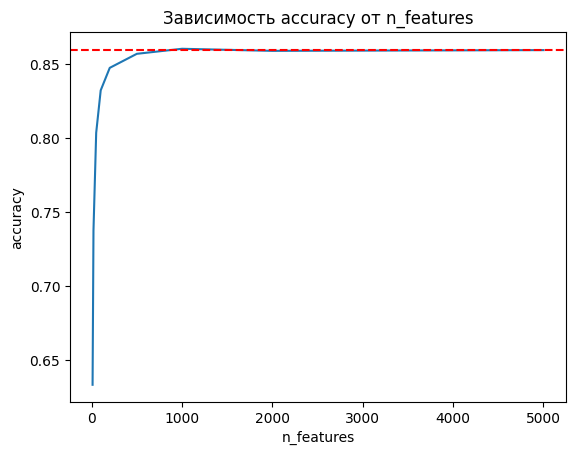

In [17]:
import matplotlib.pyplot as plt

plt.plot(n_features_list, score_list)
plt.axhline(score_list[-1], color = 'red', linestyle = '--')
plt.title('Зависимость accuracy от n_features')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.show()

Качество достаточно быстро выходит на плато, поэтому необязательно использовать большое n_features

3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

У SVM немного лучше качество, однако он дольше обучается

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


In [18]:
from homework_practice_08_rff import ORFPipeline

In [19]:
%%time
off = ORFPipeline()
X_fit = off.fit(x_train, y_train)
y_pred = off.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 4min 32s, sys: 17.2 s, total: 4min 49s
Wall time: 41.9 s


0.8619

In [20]:
%%time
off = ORFPipeline(classifier='svm', kernel = 'linear')
X_fit = off.fit(x_train, y_train)
y_pred = off.predict(x_test)
accuracy_score(y_pred, y_test)

CPU times: user 6min 56s, sys: 12.3 s, total: 7min 8s
Wall time: 6min 30s


0.8824

И качество, и время работы очень близко к RFF

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___ https://arxiv.org/pdf/2402.16481

___описание идеи:___ В статье рассказыается о Laplacian Eigenmaps и Diffusion Maps - методах нелинейного снижения размерности, которые основаны на использовании собственных значений и собственных векторов (не)нормализованных графов Лапласа. Они особенно полезны, когда данные выборки лежат на низкоразмерном многообразии, вложенном в высокоразмерное евклидово пространство.

Реализовать уже не успел, чет я поздновато сел за это, а мне еще 17-го выступать с докладом по эконометрике((

In [ ]:
# 。゜゜(´Ｏ`) ゜゜。

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 

$$
Q(w) = \frac{1}{2} ||K w + b I - y||^2 + \frac{\lambda}{2} w^T K w,
$$ где $b$ - bias, $I$ - единичный вектор

$$
\nabla_w Q(w, b) = K^{T} (K w  + b I - y) + \lambda K w
$$

$$
\nabla_b Q(w, b) = I^T (K w + b I - y)
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [21]:
from homework_practice_08_kernel_regression import KernelRidgeRegression

Сгенерируем данные

In [23]:
import scipy.stats as sts
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = sts.norm.rvs(size=[10000, 20])
y = sts.norm.rvs(size=[10000, 1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [24]:
%%time
krr_an = KernelRidgeRegression(method="analytical")
krr_an.fit(x_train, y_train)
y_pred = krr_an.predict(x_train, x_test)
mean_squared_error(y_pred, y_test)

CPU times: user 1min 15s, sys: 6.38 s, total: 1min 22s
Wall time: 16.8 s


1.0359110702424645

In [25]:
krr_grad = KernelRidgeRegression()
krr_grad.fit(x_train, y_train)
y_pred = krr_grad.predict(x_train, x_test)
mean_squared_error(y_pred, y_test)

100%|███████████████████████████████████████| 1000/1000 [10:32<00:00,  1.58it/s]


1.134290176371013

Оба метода работают!

In [26]:
%%time
rff = RFFPipeline(classifier = 'linreg', use_PCA=False)
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
mean_squared_error(y_pred, y_test)

CPU times: user 19.3 s, sys: 1.57 s, total: 20.9 s
Wall time: 3.16 s


1.1890413199775163

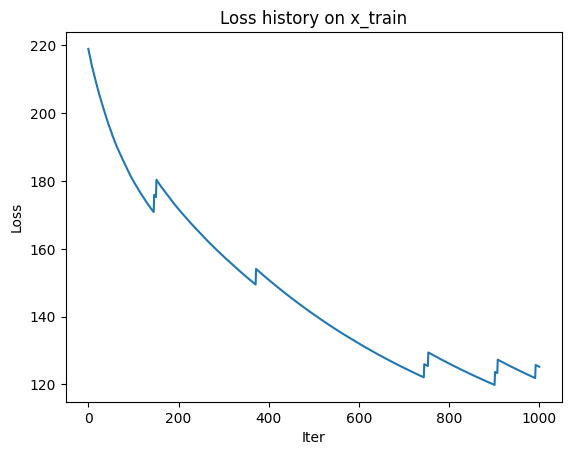

In [27]:
plt.plot(krr_grad.loss_history, label = 'krr')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Loss history on x_train')
plt.show()

KRR дает качество получше, чем RFF, но градиентный метод KRR работает очень долго, а аналитический - немного медленнее, чем RFF